# Partial Discharge Signal Denoising using Optimized Wavelet [Part 1]

## *Preprocessing*

This Python script performs the necessary signal **preprocessing** techniques required before **denoising** is performed.
A clean partial discharge (PD) signal can be passed through this script to extract singular pulses from a pulse train, as well as to
contaminate it with additive white Gaussian noise (AWGN), narrowband interference, or even a combination of both (AWGN+narrowband).

The following functions are performed in this script:
1. Define 1D-signal as x,y representation of time-amplitude.
2. Obtain list of peak heights and positions [supports multiple peak finding].
3. Visualisation of PD pulse train with peaks.
4. Extraction of singular PD pulses from pulse train by selecting random peaks [supports multiple pulse extraction].
5. Visualisation of singular PD pulses.
6. AWGN noise definition.
7. Addition of AWGN or narrowband interference, or even a combination of both.
8. Saving of extracted PD pulses, both in clean & noisy form.


### 1. Installation of modules

Use the command 'pip install [module name]' in the terminal to install required modules.

In [1]:
import warnings
warnings.filterwarnings("ignore")
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install scipy

You should consider upgrading via the 'C:\Users\melro\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\melro\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\melro\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\melro\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


### 2. Import statements

In [2]:
import os
import pandas as pd, numpy as np, random
from numpy import sum, isrealobj, sqrt
from numpy.random import standard_normal
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, resample, spectrogram
from math import sqrt
from timeit import default_timer as timer

### 3. Initialization of timer

Timer allows us to determine the elapsed time for this Python script.

In [3]:
start = timer()

### 4. Definition of functions

In [4]:
def define_samples_as_array(data):
    """
    Function converts the 1D-signal into x,y representation; y is amplitude, x is sample number.
    - Sampling time is (no. of sampling points)/(sampling frequency) = 1s; obtained from presentation slides
    - No. of sampling points = 500002 samples
    - Sampling frequency is 500002 samples/sec = 0.5MHz
    """

    x = np.linspace(0,len(data), len(data))
    data = pd.DataFrame(data).to_numpy()
    data = data.ravel()
    y = data

    return x,y

def get_peaks(x,y):
    """
    Function obtains peak height and peak position from the input x & y values, derived from define_samples_as_array().
    - Height is minimum required height
    - Threshold is minimum required threshold, ie vertical distance from neighbour
    - Prominence measures how much a peak stands out from the surrounding baseline
    """

    peaks = find_peaks(y, height=1.0, threshold=0.2, prominence=0.8)
    #print(peaks)
    height = peaks[1]['peak_heights']
    peak_pos = x[peaks[0]]

    return height, peak_pos

def plot_peaks(x,y, height, peak_pos):
    """
    Function plots peaks [height and position] in the signal using x, y, peak height & peak position from get_peaks().
    """
    fig = plt.figure()
    plt.title("Peaks in full PD signal")
    ax = fig.subplots()
    ax.plot(x,y)
    ax.scatter(peak_pos, height, color='r', s=15, marker='D', label='Maxima')
    ax.legend()
    plt.ylabel('Amplitude [mV]')
    plt.xlabel('Samples')
    ax.grid()
    plt.show()

def get_pulses(x,y, peak_pos, num_pulses, length, file_name):
    """
    Function extracts singular pulses from the full signal within a specified window 'length'.
    Randomly gets a value within (length-10) to determine where pulse peak should be placed
    (how much padding to the left).
    Using pulse index, places peak with shift by random value generated.
    Creates new signal with desired length.
    """

    peak_index = list(map(int, peak_pos))
    pulse_index = random.choices(peak_index, k=num_pulses)
    #print(pulse_index)

    new_signal = np.empty((num_pulses, length))

    for idx, j in enumerate(pulse_index):
        peak_shift = random.choice(range(0, length-10))
        pulses = y[j-peak_shift:j-peak_shift+length]
        #print(pulses)
        new_signal[idx, :] = pulses

    for idx, j in enumerate(new_signal):
        lines = new_signal[idx]
        output = "\n".join(map(str, lines))
        new_filename = "PD_Data/Pulses/"+file_name[8:]+"_Pulse"+str(idx+1)+".txt"
        #print(new_filename)
        with open(new_filename, 'w') as f:
            f.writelines(output)

    #print(new_signal)
    return new_signal

def plot_pulse(data, title):
    """
    Function plots the singular pulses obtained from get_pulses().
    Differs from plot_peaks(); intended to display only singular pulses/peaks.
    """
    fig = plt.figure()
    plt.title(title)
    ax = fig.subplots()
    ax.plot(data)
    ax.grid()
    plt.ylabel('Amplitude [mV]')
    plt.xlabel('Samples')
    plt.show()

def awgn(data, SNRdB, L=1):
    """
    Function adds AWGN noise to the input signal. AWGN noise vector is added to signal 'data' to generate
    a resulting signal vector 'r' of specified SNR in dB.
    It also returns the noise vector 'n' that is added to the signal 's' and the power spectral density N0
    of noise added (removed output).
    Parameters:
        data : input/transmitted signal vector
        SNRdB : desired signal-to-noise ratio (expressed in dB) for the received signal
        L : oversampling factor (applicable for waveform simulation) default L = 1.
    Returns:
        r : received signal vector (r=s+n)
    """

    gamma = 10**(SNRdB/10)  # SNR to linear scale
    if data.ndim == 1:  # if s is single dimensional vector
        P = L * sum(abs(data) ** 2) / len(data)  # Actual power in the vector
    else:  # multi-dimensional signals like MFSK
        P = L * sum(sum(abs(data) ** 2)) / len(data)  # if s is a matrix [MxN]
    N0 = P / gamma  # Find the noise spectral density
    if isrealobj(data):  # check if input is real/complex object type
        n = sqrt(N0 / 2) * standard_normal(data.shape)  # computed noise
    else:
        n = sqrt(N0 / 2) * (standard_normal(data.shape) + 1j * standard_normal(data.shape))
    r = data + n  # received signal

    return r

def add_noise(pulse, SNR, idx, noise_type):
    """
    Function adds noise to the input signal; two noise types available, with a third being a combination of both noises.
    Noisy signal frequency is set to 20MHz, dt = 5*(10^8); allows for accurate representation of
    high frequency narrowband interference.
    Parameters:
          pulse: input signal (singular pulse)
          SNR: desired signal-to-noise ratio (expressed in dB); applies only to the AWGN noise
          idx: index of the input signal; used for naming of noisy output signal
          noise_type: selection of noise type; '0' refers to AWGN only, '1' refers to narrowband interference only,
                      and '2' refers to AWGN+narrowband interference
    """

    f_pulse = 0.5*(10**6)   # Pulse frequency
    f_sampling = 20*(10**6) # Final PD sampling frequency
    num_samples = len(pulse)*int((f_sampling/f_pulse))
    resampled_pulse = resample(pulse, num_samples)

    dt = 1/f_sampling
    t = np.arange(0,num_samples*dt,dt)
    n = np.arange(0,num_samples,1)

    fo1 = 2*(10**6)
    fo2 = 10*(10**6)
    fo3 = 15*(10**6)
    c1 = 2.0*np.sin(2*np.pi*(fo1/f_sampling)*n)
    c2 = 2.5*np.sin(2*np.pi*(fo2/f_sampling)*n)
    c3 = 2.0*np.sin(2*np.pi*(fo3/f_sampling)*n)

    narrowband_noise = c1+c2+c3

    match noise_type:
        case 0:
            noisy_signal = awgn(resampled_pulse,SNR)
        case 1:
            noisy_signal = resampled_pulse + narrowband_noise
        case 2:
            noisy_signal = awgn(resampled_pulse,SNR) + narrowband_noise

    lines = noisy_signal
    output = "\n".join(map(str, lines))
    new_filename = "PD_Data/NoisyPulses/" + file_name[8:] + "_NoisyPulse" + str(
        idx + 1) + ".txt"
    # print(new_filename)
    with open(new_filename, 'w') as f:
        f.writelines(output)

    return noisy_signal

def spectro(pulse):
    """
    Functions plots a spectrogram of the pulse. High noise levels obscure the pulse, making it less visible.
    """
    f_sampling = 20 * (10 ** 6)  # Final PD sampling frequency
    f, t, Sxx = spectrogram(pulse, f_sampling)
    plt.figure(figsize=(6, 5))
    plt.title("Spectrogram")
    plt.pcolormesh(t, f, Sxx, shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()

### 5. Calling functions

Call functions below.
Simply change the file path to extract new PD pulses.
Files generated will be named automatically.
In ***get_pulses()***, the 4th argument defines the number of pulses generated, while the 5th one defines the pulse length.
To change the SNR & noise type for noisy pulses, modify the 2nd & 4th argument of ***add_noise()*** in the ***for()*** loop.

Accessed: PD_Data/Void3


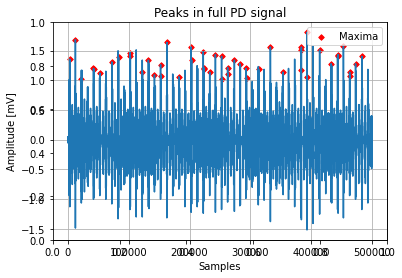

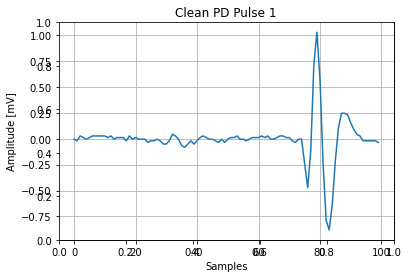

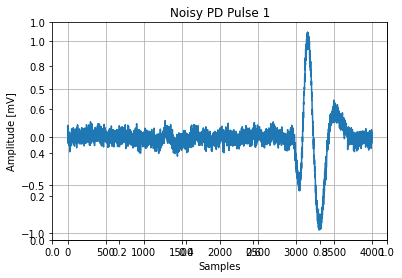

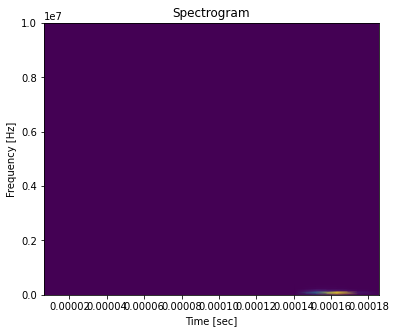

In [5]:
file_path = 'PD_Data/Void3.txt'
file_name = os.path.splitext(file_path)[0]
print("Accessed: "+file_name)
corona1 = pd.read_csv(file_path)
x,y = define_samples_as_array(corona1)
height,peak_pos = get_peaks(x,y)
plot_peaks(x,y, height, peak_pos)
new_signal = get_pulses(x,y, peak_pos, 1, 100, file_name)   # 100 samples = 0.2ms

for idx, i in enumerate(new_signal):
    title = "Clean PD Pulse " + str(idx+1)
    plot_pulse(i, title)
    noisy = add_noise(i, 10, idx, 0)    # Pulse, SNR, index, noise type
    title = "Noisy PD Pulse " + str(idx+1)
    plot_pulse(noisy, title)
    spectro(noisy)
    pass

### 6. End of script

Completion status is presented, and timer is ended here.

In [6]:
end = timer()
elapsed = end-start
print("\n===Completed===\n")
print("Elapsed Time: ",elapsed,"secs\n")


===Completed===

Elapsed Time:  1.106663500002469 secs

